In [1]:
import torch
# import scipy.linalg
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D

from tqdm.auto import trange

sys.path.append("./lib")
from swspd import *
from utils_spd import busemann_spd
from logm import logm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Busemann

In [3]:
theta = torch.randn(1000, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [4]:
M = torch.eye(2, device=device)
M = M.reshape((1, 2, 2))
M = M.repeat(10, 1, 1)

## Compute logM in advance since we cannot batch it
log_M = torch.zeros(M.shape, device=device)
for k in range(len(log_M)):
    log_M[k] = logm(M[k])

In [5]:
b = busemann_spd(log_M, dA)

In [6]:
print(log_M.shape, dA.shape)
print(b.shape)

torch.Size([10, 2, 2]) torch.Size([1000, 2, 2])
torch.Size([10, 1000])


In [7]:
b

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], device='cuda:0')

In [8]:
ts = torch.linspace(-10,10,200).to(device)
ts = ts.reshape(ts.shape[0],1,1)
ts = ts.repeat(1,2,2)

In [9]:
theta = torch.randn(3, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [10]:
M = torch.linalg.matrix_exp(ts[:,None]*A[None])

In [11]:
print(ts.shape, A.shape, M.shape)

torch.Size([200, 2, 2]) torch.Size([3, 2, 2]) torch.Size([200, 3, 2, 2])


In [12]:
L = np.zeros((ts.shape[0],M.shape[1],A.shape[0]))

for i, t in enumerate(ts):
    log_M = torch.zeros(M[i].shape, device=device)
    for k in range(len(log_M)):
        log_M[k] = logm(M[i][k])
    
    b = busemann_spd(log_M, dA)
    L[i] = b.detach().cpu()

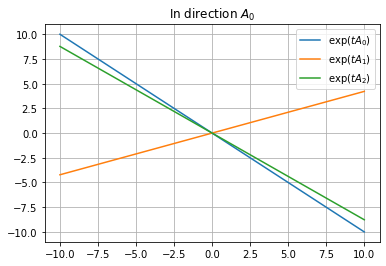

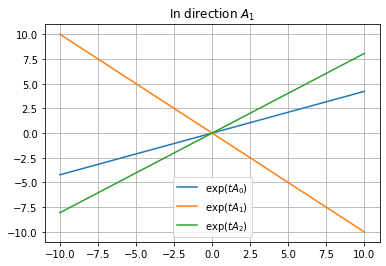

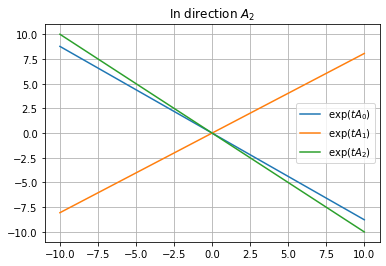

In [13]:
for i in range(A.shape[0]):
    for k in range(3):
        plt.plot(ts[:,0,0].cpu(), L[:,k,i], label=r"$\exp(t A_"+str(k)+r")$")
    plt.title(r"In direction $A_"+str(i)+r"$")
    plt.legend()
    plt.grid(True)
    plt.show()

### Sliced-Wasserstein

In [14]:
X0 = M[:,0]
X1 = M[:,1]

In [15]:
sw = sliced_wasserstein_spd(X0, X1, 500, device=device).item()
sw

10.774989128112793

In [16]:
X0 = M[:,0]
X1 = M[:,0]

sw = sliced_wasserstein_spd(X0, X1, 500, device=device).item()
sw

0.0

#### Test Wishart Distribution

In [17]:
m0 = D.Wishart(torch.Tensor([2]).to(device), torch.eye(2, device=device))

In [18]:
B0 = m0.sample((100,))[:,0]

/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/distributions/wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [19]:
B0.shape

torch.Size([100, 2, 2])

In [21]:
sw = sliced_wasserstein_spd(X0, B0, 500, device=device).item()
sw

6.961625099182129

In [55]:
ts = torch.linspace(0.1,10,200)
L = np.zeros((20,200))

for k in range(10):
    pbar = trange(len(ts))
#     pbar = range(len(ts))
    for i in pbar:
        t = ts[i]
        mt = D.Wishart(torch.tensor([2]).to(device), t*torch.eye(2, device=device))
        B0 = m0.sample((100,))[:,0]
        Bt = mt.sample((100,))[:,0]

        sw = sliced_wasserstein_spd(B0, Bt, 500, device=device).item()
        L[k, i] = sw

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

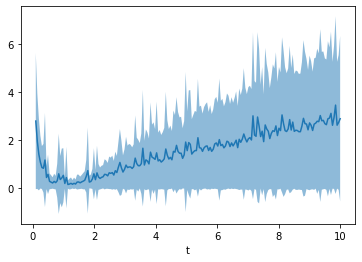

In [56]:
m = np.mean(L, axis=0)
s = np.std(L, axis=0)

plt.plot(ts, m)
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t")
plt.show()

In [111]:
mt = D.Wishart(torch.tensor([2]), torch.eye(2))
B0 = m0.sample((10000,))[:,0]
Bt = mt.sample((10000,))[:,0]

sw = sliced_wasserstein_spd(B0, Bt, 500, device=device).item()
sw

/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


0.016155999153852463

In [57]:
ts = torch.linspace(1.1,10,200)
L = []

pbar = trange(len(ts))

for i in pbar:
    t = ts[i]
    mt = D.Wishart(t*torch.tensor([1]), torch.eye(2))
    B0 = m0.sample((100,))[:,0]
    Bt = mt.sample((100,))[:,0]
    
    sw = sliced_wasserstein_spd(B0, Bt, 500, device=device).item()
    L.append(sw)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/distributions/wishart.py:94: UserWarning: Low df values detected. Singular samples are highly likely to occur for ndim - 1 < df < ndim.
  warnings.warn("Low df values detected. Singular samples are highly likely to occur for ndim - 1 < df < ndim.")
/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/distributions/wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/clement/anaconda3/envs/pytorch/lib/python3.7/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


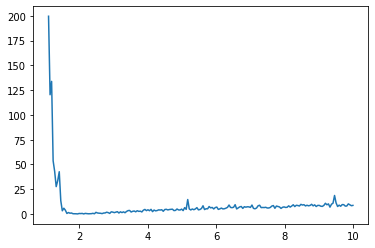

In [58]:
plt.plot(ts, L)
plt.show()